## Framework

1. Accesss stock price data
2. Calculate the return of the stock
3. Model the return of the stock
4. Use the model to predict the future return of the stock
5. Use the predicted return to predict the future price of the stock


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import yfinance as yf
# import mplfinance as mpf

# plt.style.use("default")
plt.rcParams['font.weight'] = "light"
plt.rcParams['axes.labelweight'] = "light"
plt.rcParams['axes.axisbelow'] = True # Set axes and grid elements to be below the figure

# %matplotlib widget

## Data Sourcing

In [2]:
intc = pd.read_csv("data/INTC.csv", index_col=0, parse_dates=True) # Index column is date, parse_dates=True to convert to datetime

In [3]:
CURRNET_PRICE = intc["Adj Close"][-1]
CURRENT_TIME = intc.index[-1]
TARGET_TIME = pd.Timestamp("2024-03-01")
T = TARGET_TIME - CURRENT_TIME

intc.head()

/var/folders/p6/smj7c6c1417csf_h79x5rk4h0000gn/T/ipykernel_5721/2702494421.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  CURRNET_PRICE = intc["Adj Close"][-1]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-07,47.630001,48.750000,47.590000,48.720001,42.491024,29913200
2018-11-08,48.490002,49.290001,48.459999,48.990002,42.726501,26581700
2018-11-09,48.790001,49.029999,47.869999,48.110001,41.959011,21761400
2018-11-12,47.709999,47.799999,46.599998,46.650002,40.685677,24412800
2018-11-13,46.990002,48.250000,46.990002,47.389999,41.331062,29315900


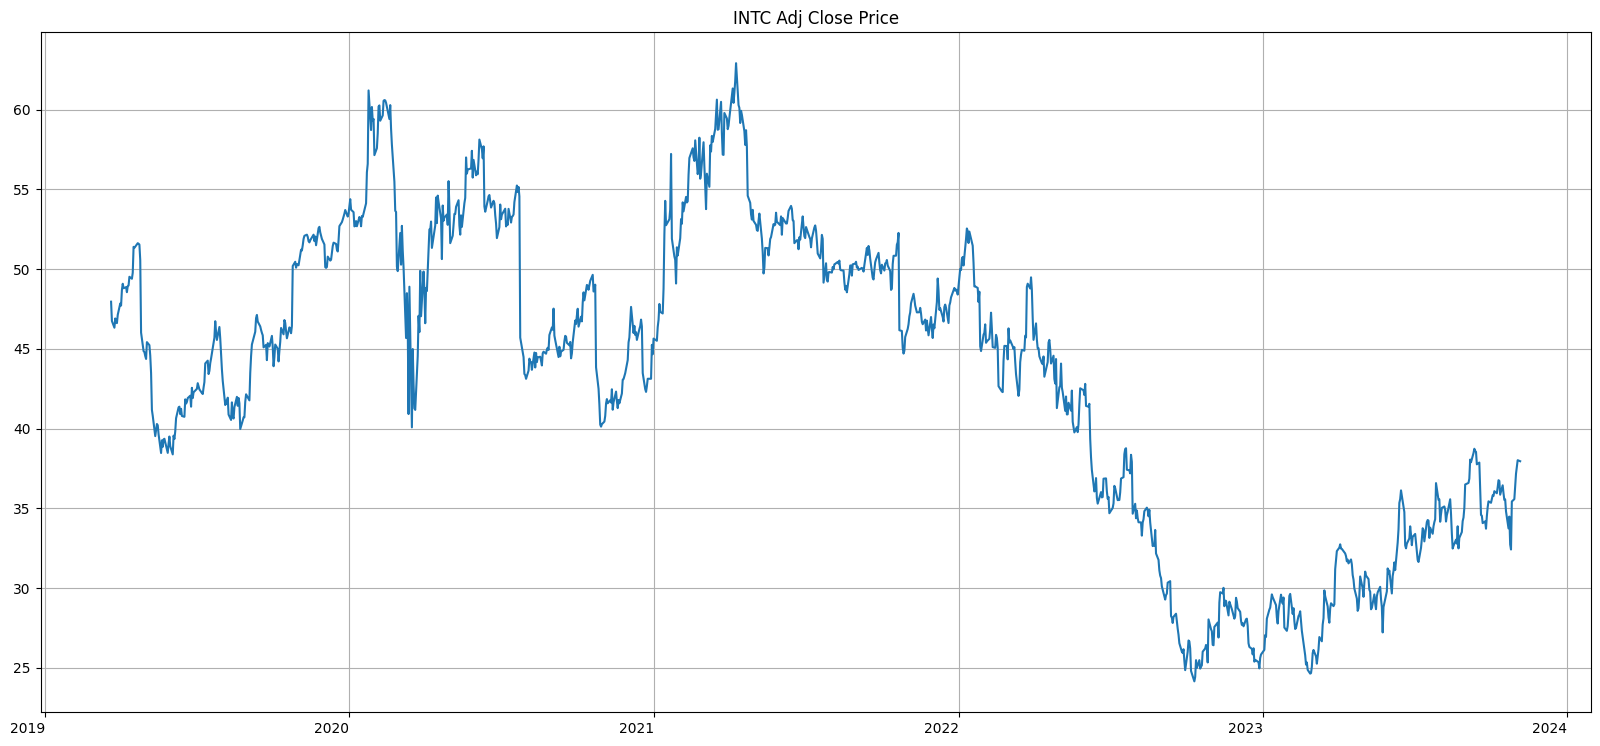

In [22]:
plt.figure("INTC Adj Close Price", clear = True)
intc["Adj Close"].plot(kind = "line", figsize = (20, 10), title = "INTC Adj Close Price")
plt.xlabel(None) # type: ignore
plt.xticks(rotation = 0)
# Add month ticks

plt.grid()
plt.show()

In [5]:
# Create return and log-return
intc["Return"] = intc["Adj Close"].pct_change()
intc["Log Return"] = np.log(1 + intc["Return"])

# Create 30, 60, 90 day rolling volatility
intc["Volatility 10"] = intc["Log Return"].rolling(10).std() * np.sqrt(252)
intc["Volatility 30"] = intc["Log Return"].rolling(30).std() * np.sqrt(252)
intc["Volatility 90"] = intc["Log Return"].rolling(90).std() * np.sqrt(252)

# Remove NaN values caused by rolling volatility
intc.dropna(inplace = True)

In [6]:
intc.tail(10)[::-1]

,Open,High,Low,Close,Adj Close,Volume,Return,Log Return,Volatility 10,Volatility 30,Volatility 90
Date,,,,,,,,,,,
2023-11-06,38.020000,38.200001,37.849998,37.950001,37.950001,23877200,-0.001710,-0.001711,0.555598,0.374467,0.361050
2023-11-03,38.000000,38.320000,37.669998,38.139999,38.014999,30493400,0.011671,0.011603,0.593863,0.374145,0.362802
2023-11-02,37.580002,37.820000,36.910000,37.700001,37.576443,35440000,0.010995,0.010935,0.612171,0.376635,0.363512
2023-11-01,36.500000,37.320000,36.279999,37.290001,37.167786,41710700,0.021644,0.021413,0.611775,0.375999,0.364912
2023-10-31,35.660000,36.570000,35.619999,36.500000,36.380375,41185200,0.022695,0.022442,0.608766,0.397066,0.363644
2023-10-30,35.470001,35.959999,34.919998,35.689999,35.573029,36656300,0.004221,0.004212,0.600493,0.411454,0.362098
2023-10-27,34.660000,36.380001,34.599998,35.540001,35.423523,84128200,0.092866,0.088804,0.607228,0.411297,0.362234
2023-10-26,32.889999,33.220001,32.150002,32.520000,32.413418,59142500,-0.009443,-0.009488,0.347495,0.311172,0.346088
2023-10-25,34.180000,34.450001,32.549999,32.830002,32.722404,44658500,-0.050882,-0.052222,0.352046,0.311260,0.351486


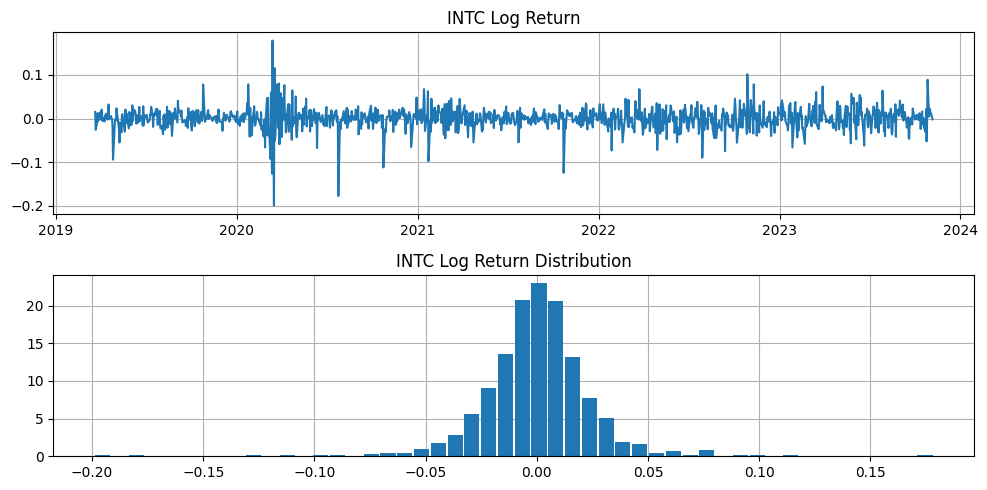

In [7]:
# Plot the movement of log-return and distribution of log-return
fig, ax = plt.subplots(2, 1, figsize = (10, 5), clear = True)

fig.set_label("INTC Log Return")

ax[0].plot(intc["Log Return"])
ax[0].set_title("INTC Log Return")
ax[0].grid()

ax[1].hist(intc["Log Return"], bins = 50, density = True, rwidth = 0.9)
ax[1].set_title("INTC Log Return Distribution")
ax[1].grid()

plt.tight_layout()
plt.show()

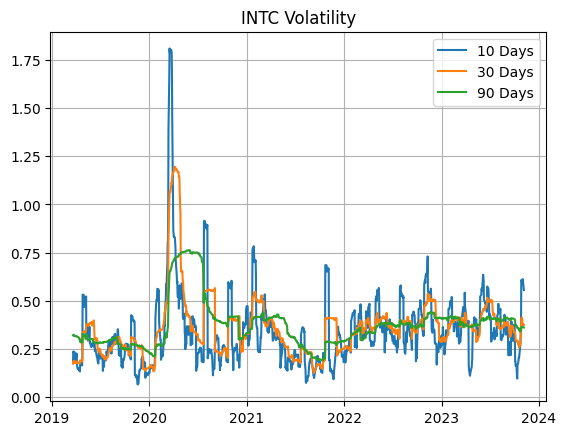

In [8]:
plt.figure("INTC Volatility", clear = True)
plt.plot(intc["Volatility 10"], label = "10 Days")
plt.plot(intc["Volatility 30"], label = "30 Days")
plt.plot(intc["Volatility 90"], label = "90 Days")
plt.title("INTC Volatility")
plt.legend()
plt.grid()
plt.show()

## Modelling

#### Procedure

Model stock return using GARCH(1,1) model, then extract the conditional variance of the model to predict the future stock price.

#### GARCH(1,1) Model

The GARCH(1,1) model is defined as:

$$
r_t = \mu + \epsilon_t \\
\epsilon_t = \sigma_t z_t \\
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where $z_t$ is a white noise with mean 0 and variance 1.

In [9]:
from statsmodels.tsa import stattools

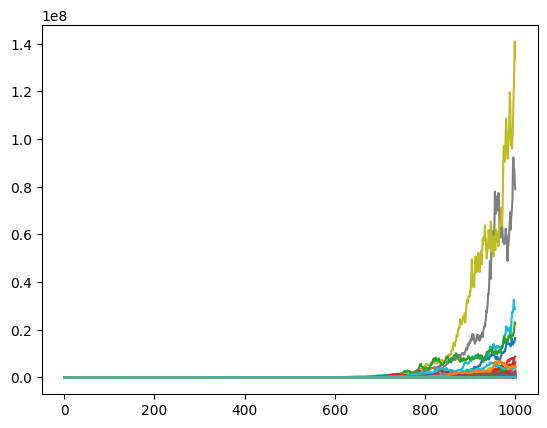

In [10]:
def monte_carlo(T, S0, mu, sigma, n, m):
    """
    T: Time period
    S0: Initial price
    mu: Expected return
    sigma: Volatility
    n: Number of simulations
    m: Number of steps
    """

    
    dt = T/m
    S = np.zeros((m+1, n))
    S[0] = S0
    for t in range(1, m+1):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn(n))
    return S

plt.figure("Monte Carlo", clear = True)
plt.plot(monte_carlo(T.days, CURRNET_PRICE, 0.1, 0.2, 100, 1000))
plt.show()